In [1]:
from torchvision import transforms, datasets
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm 

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
device = "mps:0"

### Data

We will use MNIST dataset, and split into train/test datasets.

In [2]:
dset = datasets.MNIST(root='data/', download=True, transform=transforms.ToTensor())
train_len = int(0.7*len(dset))
train_dset, test_dset = torch.utils.data.random_split(dset, [train_len, len(dset)-train_len])

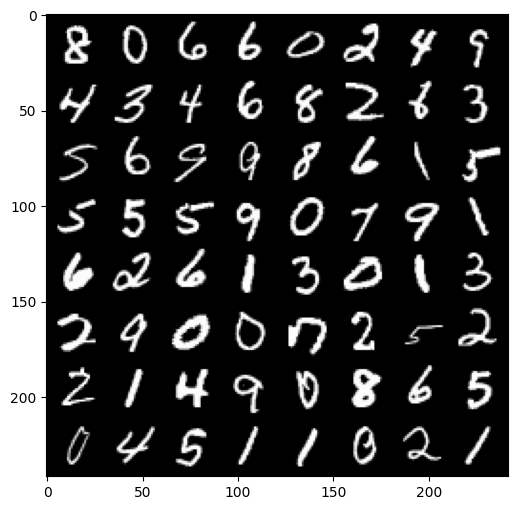

In [3]:
loader = torch.utils.data.DataLoader(train_dset, batch_size=128, num_workers=2, pin_memory=True, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=128, num_workers=2, pin_memory=True)

it = iter(loader)
x, _ = next(it)
x = torchvision.utils.make_grid(x[0:64])

plt.figure(figsize=(6,6))
plt.imshow(x.permute(1,2,0))
plt.show()

## Models

First, define Encoder neural network. 
In the forward() function, it will map images $X$ to latent features $Z$, via
a series of convolution layers and ReLU nonlinearities.

In [4]:
class EncoderTransform(nn.Module):
    def __init__(self, latent_dim=8):
        """
        Encoder network that transforms 28x28x1 images into a quantized latent space
        
        Args:
            latent_dim (int): Dimension of the latent space
        """
        super().__init__()
        self.latent_dim = latent_dim
        
        # Fully connected layers with BatchNorm and Leaky ReLU
        self.fc1 = nn.Linear(784, 512)
        self.bn1 = nn.BatchNorm1d(512)
        
        self.fc2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.fc3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        
        self.fc4 = nn.Linear(128, 128)
        self.bn4 = nn.BatchNorm1d(128)
        
        # Final FC layer to latent space with tanh activation
        self.fc5 = nn.Linear(128, latent_dim)
        # self.bn5 = nn.BatchNorm1d(latent_dim)
        
    def forward(self, x):
        # Input size should be [batch_size, 1, 28, 28]
        batch_size = x.size(0)
        
        # Flatten the input
        x = x.view(batch_size, -1)  # Reshape to [batch_size, 784]
        
        # FC layers with BatchNorm and Leaky ReLU
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = F.leaky_relu(self.bn4(self.fc4(x)))
        
        # Final layer with tanh activation
        x = self.fc5(x)
        
        return x

In [5]:
class DecoderTransform(nn.Module):
    def __init__(self, latent_dim=10):
        """
        Decoder network that transforms a latent vector back to a 28x28x1 image
        
        Args:
            latent_dim (int): Dimension of the latent space
        """
        super().__init__()
        
        # FC layers with BatchNorm and Leaky ReLU
        self.fc1 = nn.Linear(latent_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        
        self.fc2 = nn.Linear(128, 512)
        self.bn2 = nn.BatchNorm1d(512)
        
        # # Reshape to prepare for convolutional transpose layers
        # self.fc3 = nn.Linear(512, 4 * 4 * 32)
        # self.bn3 = nn.BatchNorm1d(4 * 4 * 32)
        
        # Transposed convolution layers
        # 4x4x32 -> 11x11x64
        self.convT1 = nn.ConvTranspose2d(32, 64, kernel_size=5, stride=2)
        self.bn4 = nn.BatchNorm2d(64)
        
        # 11x11x64 -> 25x25x128
        self.convT2 = nn.ConvTranspose2d(64, 128, kernel_size=5, stride=2)
        self.bn5 = nn.BatchNorm2d(128)
        
        # 25x25x128 -> 28x28x1
        self.convT3 = nn.ConvTranspose2d(128, 1, kernel_size=4, stride=1)
        
    def forward(self, x):
        # Input is latent vector with dimension [batch_size, latent_dim]
        batch_size = x.size(0)
        
        # FC layers with BatchNorm and Leaky ReLU
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        
        # Unflatten: Reshape to [batch_size, 32, 4, 4]
        x = x.view(batch_size, 32, 4, 4)
        
        # Transposed Convolution layers
        # ConvT (stride=2) with BatchNorm and Leaky ReLU: 4x4x32 -> 11x11x64
        x = F.leaky_relu(self.bn4(self.convT1(x)))
        
        # ConvT (stride=2) with BatchNorm and Leaky ReLU: 11x11x64 -> 25x25x128
        x = F.leaky_relu(self.bn5(self.convT2(x)))
        
        # ConvT (stride=1) with Sigmoid: 25x25x128 -> 28x28x1
        x = torch.sigmoid(self.convT3(x))
    

        return x

Lastly, we define the NTCCompressor, which uses the Encoder and Decoder.
It also uses the EntropyBottleneck layer which takes in a latent feature $z$, and outputs its quantized version $\tilde{z}$, as well as its likelihoods $p_{\tilde{z}}(\tilde{z})$. 

The EntropyBottleneck layer is complex, so we will not go over all the details of its implementation (it resides in a separate file). In summary, it uses a *factorized prior*, meaning that it assumes the components to be independent. Hence, it just needs to model a single univariate density, which can be used to estimate the likelihoods of the entire quantized vector $\tilde{z}$. 

During training, we estimate the rate by adding uniform noise as a stand-in for quantization and computing the average negative log likelihood. During evaluation, we use hard quantization, and pass the quantized symbols (and likelihoods) to an arithmetic encoder.

In [6]:
from compressai.entropy_models import EntropyBottleneck

In [7]:
class NTC(nn.Module):
    def __init__(self, dy):
        super().__init__()

        self.dy = dy
        self.g_a = EncoderTransform(latent_dim=dy)
        self.g_s = DecoderTransform(latent_dim=dy)
        self.entropy_bottleneck = EntropyBottleneck(channels=dy)

    def forward(self, x):
        # x : [B, d]
        y = self.g_a(x) # [B, d]

        # sample dither
        u = torch.rand_like(y) - 0.5
        y_tilde = y + u

        lik = self.entropy_bottleneck._likelihood(y_tilde.permute(1,0).unsqueeze(1))
        lik = lik.squeeze().permute(1,0)
        x_hat = self.g_s(y_tilde)
        return x_hat, lik
    
    def inference(self, x):
        with torch.no_grad():
            y = self.g_a(x) # [B, d]
            y_hat = torch.round(y)

            y_lik = self.entropy_bottleneck._likelihood(y_hat.permute(1,0).unsqueeze(1))
            y_lik = y_lik.squeeze().permute(1,0)
            x_hat = self.g_s(y_hat)
        return x_hat, y_lik

## Loss functions

For the rate, it is defined as $R = \mathbb{E}_X[-\log_2 p_{\tilde{z}}(\tilde{z})]$.

For the distortion, it is defined as $D = \mathbb{E}_X[\|X-\hat{X}\|_2^2]$.

In [8]:
"""
Define a rate loss, which is defined as the average information of the model.
"""
def rate_loss(likelihoods):
    batch_size = likelihoods.shape[0]
    rate_batch = -torch.sum(torch.log2(likelihoods)) # total rate of batch (factorized prior)
    rate_per_sample = rate_batch / batch_size # rate per sample
    return rate_per_sample

"""
Define a distortion loss, which is squared-error distortion on the images.
"""
def distortion_loss(x, x_hat):
    # SED = squared-error-distortion
    SED_batch = torch.linalg.vector_norm(x-x_hat, dim=(1,2,3))**2 # vector of SED for each element in batch
    SED_per_sample = torch.mean(SED_batch)
    return SED_per_sample

## Training 

train_one_epoch() will go through the entire dataset once, updating gradients
of the model for every batch of samples that it processes. 
The loss function we optimize is $R + \lambda D$, the joint rate-distortion loss.

In [9]:
def train_one_epoch(model, optimizer, loader, lmbda):
    model.train()
    
    rate_epoch, distortion_epoch = 0, 0
    for x, _ in tqdm.tqdm(loader):
        
        x = x.to(device) # Send batch to the GPU.
        optimizer.zero_grad()  # Clear gradients.
        x_hat, likelihoods = model(x)  # Forward pass through the model.
        rate = rate_loss(likelihoods) # compute average rate.
        distortion = distortion_loss(x, x_hat) # compute average distortion.
        RD_loss = rate + lmbda * distortion # compute loss function.
        RD_loss.backward()  # Backward pass (backpropagate gradients through model).
        optimizer.step()  # Update model parameters.

        rate_epoch += rate.item()
        distortion_epoch += distortion.item()

    return rate_epoch / len(loader), distortion_epoch / len(loader)

In [17]:
"""
Define the model, and choose Adam as the optimization algorithm, with learning rate 1e-3.
"""
model = NTC(dy=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [18]:
"""
Set lmbda, the rate-distortion tradeoff parameter, and begin training.
"""
lmbda=10.
for epoch in range(1, 11):
    r, d = train_one_epoch(model, optimizer, loader, lmbda=lmbda)
    print(f'Epoch: {epoch:02d}, rate: {r:.4f} bps, distortion: {d:.4f}')

100%|██████████| 329/329 [00:13<00:00, 25.26it/s]


Epoch: 01, rate: 235.0865 bps, distortion: 32.0732


100%|██████████| 329/329 [00:12<00:00, 25.34it/s]


Epoch: 02, rate: 114.9267 bps, distortion: 15.9592


100%|██████████| 329/329 [00:13<00:00, 25.09it/s]


Epoch: 03, rate: 83.2595 bps, distortion: 14.6346


100%|██████████| 329/329 [00:13<00:00, 25.06it/s]


Epoch: 04, rate: 72.2730 bps, distortion: 13.2458


100%|██████████| 329/329 [00:12<00:00, 25.39it/s]


Epoch: 05, rate: 65.5550 bps, distortion: 11.9515


100%|██████████| 329/329 [00:13<00:00, 25.15it/s]


Epoch: 06, rate: 61.1015 bps, distortion: 11.0595


100%|██████████| 329/329 [00:12<00:00, 25.31it/s]


Epoch: 07, rate: 58.4993 bps, distortion: 10.2838


100%|██████████| 329/329 [00:12<00:00, 25.40it/s]


Epoch: 08, rate: 56.8035 bps, distortion: 9.9752


100%|██████████| 329/329 [00:13<00:00, 24.97it/s]


Epoch: 09, rate: 55.7936 bps, distortion: 9.5309


100%|██████████| 329/329 [00:12<00:00, 25.38it/s]

Epoch: 10, rate: 55.1147 bps, distortion: 9.2362


## Evaluating Trained Compressor

In [19]:
"""Sample 8 test images"""
it = iter(test_loader)
x,_ = next(it)
x = x[0:8]
model = model.to('cpu')

In [20]:
x_hat, y_hat = model.inference(x)
bits = torch.sum(-torch.log2(y_hat)) / (x.shape[0])

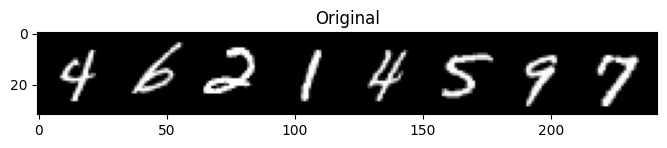

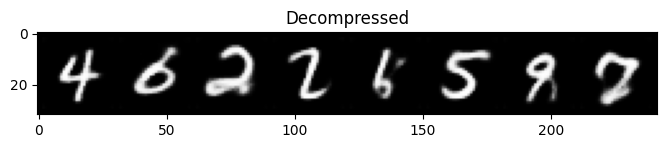

Avg. rate=49.99151611328125, Avg. distortion=30.268


In [22]:
"""Plot the original and reconstructed images."""
x_grid = torchvision.utils.make_grid(x).cpu().detach()
x_hat_grid = torchvision.utils.make_grid(x_hat).cpu().detach()

plt.figure(figsize=(8,4))
plt.imshow(x_grid.permute(1,2,0))
plt.title('Original')
plt.show()

plt.figure(figsize=(8,4))
plt.imshow(x_hat_grid.permute(1,2,0))
plt.title('Decompressed')
plt.show()

print(f'Avg. rate={bits}, Avg. distortion={distortion_loss(x, x_hat):.3f}')